In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
import queue

class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]
    
    def get_neighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 8-connected but cutting corners is prohibited
        '''
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
                
        delta = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]) and \
            (self.traversable(i + d[0], j) or self.traversable(i, j + d[1])):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

    def get_size(self):
        return (self._height, self._width)

In [2]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of a move between the adjacent cells
    '''
    if abs(i1 - i2) + abs(j1 - j2) == 1: #cardinal move
        return 1
    elif abs(i1 - i2) + abs(j1 - j2) == 2: #diagonal move
        return math.sqrt(2)
    else:
        raise Exception('Trying to compute the cost of a non-supported move! ONLY cardinal and diagonal moves are supported.')

In [3]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields/methods for Node
    '''

    def __init__(self, i, j, g = 0, h = 0, F = None, parent = None, k = 0):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent

    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)
    
    def __lt__(self, other):
        return self.F < other.F or ((self.F == other.F) and (self.h < other.h))

In [4]:
class Open:
    
    def __init__(self):
        self.elements = {}
        self.heap = []
    
    def __iter__(self):
        return iter(self.elements)
    
    def __len__(self):
        return len(self.elements)

    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        
        return True

    def AddNode(self, node : Node, *args):
        if (node.i, node.j) not in self.elements or self.elements[(node.i, node.j)].g > node.g:
            self.elements.update({(node.i, node.j) : node})
            heappush(self.heap, node)
            
        return

    def GetBestNode(self, CLOSED, *args):
        best = heappop(self.heap)
        while CLOSED.WasExpanded(best):
            best = heappop(self.heap)
        del self.elements[(best.i, best.j)]
        return best

In [5]:
class Closed:
    
    def __init__(self):
        self.elements = {}


    def __iter__(self):
        return iter(self.elements)
    

    def __len__(self):
        return len(self.elements)


    def AddNode(self, item : Node):
        self.elements.update({(item.i, item.j) : item})


    def WasExpanded(self, item : Node):
        return (item.i, item.j) in self.elements

In [6]:
def diagonal_distance(i1, j1, i2, j2):
    return abs(abs(int(i1) - int(i2)) - abs(int(j1) - int(j2))) + \
            math.sqrt(2) * min(abs(int(i1) - int(i2)), abs(int(j1) - int(j2)))

In [7]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func):

    OPEN = Open()
    CLOSED = Closed()
    
    start_node = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, goal_i, goal_j))
    goal_node = Node(goal_i, goal_j, 0, 0)
    OPEN.AddNode(start_node)
    
    while not OPEN.isEmpty():
        next_node = OPEN.GetBestNode(CLOSED)
        CLOSED.AddNode(next_node)
    
        if next_node == goal_node:
            return (True, next_node, CLOSED.elements.values(), OPEN.elements.values())
            
        
        for nbr_node in grid_map.get_neighbors(next_node.i, next_node.j):
            if not CLOSED.WasExpanded(Node(i=nbr_node[0], j=nbr_node[1])):
                OPEN.AddNode( Node(i=nbr_node[0], 
                                   j=nbr_node[1], 
                                   g=next_node.g + compute_cost(next_node.i, next_node.j, nbr_node[0], nbr_node[1]), 
                                   h=heuristic_func(nbr_node[0], nbr_node[1], goal_i, goal_j),
                                   parent=next_node) )
                

    return False, None, CLOSED, OPEN

In [8]:
def make_path(goal):

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [9]:
def read_map_from_movingai_file(path):
    
    mapFile = open(path)
    count = 0
    
    mapFile.readline()
    a = mapFile.readline().split(' ')
    height = int(a[1])
    a = mapFile.readline().split(' ')
    width = int(a[1])
    mapFile.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in mapFile:
        j = 0
        for c in l:
            if c == '.' or c == 'G':
                cells[i][j] = 0
            elif c == '@' or c == 'O' or c == 'T':
                cells[i][j] = 1
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break  

    return (width, height, cells)

In [10]:
def read_tasks_from_movingai_file(path):

    tasksFile = open(path)
    tasks = []
    
    tasksFile.readline()
    for _ in range(200):
        line = tasksFile.readline().split('\t')
        mapFile = line[1]
        jStart = int(line[4])
        iStart = int(line[5])
        jGoal = int(line[6])
        iGoal = int(line[7])
        length = float(line[8])
        
        tasks.append((iStart, jStart, iGoal, jGoal, length))
    
    return tasks 

In [11]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 5
    hIm = gridMap._height * k
    wIm = gridMap._width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap._height):
        for j in range(gridMap._width):
            if(gridMap._cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for node in nodesExpanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))

In [12]:
def massive_test(search_function, *args):
    all_tasks_results = dict()
    averageNodes = 0
    averageSteps = 0
    
    all_tasks_results["corr"] = []
    all_tasks_results["len"] = []
    all_tasks_results["nc"] = []
    all_tasks_results["st"] = []
    taskNum = 1
    taskMap = Map()
    for taskCount in range(1, taskNum + 1):
        averageNodes = 0
        averageSteps = 0
        print('')
        print('               Карта ' + str(taskCount) + ', A*               ')
        mapFileName = "./maps/" + "orz103d" + ".map"
        taskFileName = "./maps/" + "orz103d" + ".map.scen"
        width, height, cells = read_map_from_movingai_file(mapFileName)
        tasks = read_tasks_from_movingai_file(taskFileName)
        
        i = 0
        taskMap.set_grid_cells(width,height,cells)
        for task in tasks:

            iStart, jStart, iGoal, jGoal, length = task
            try:
                result = search_function(taskMap, iStart, jStart, iGoal, jGoal, *args)
                nodesExpanded = result[2]
                nodesOpened = result[3]
                if result[0]:
                    path = make_path(result[1]) 
                    all_tasks_results["len"].append(path[1])
                    correct = int(path[1])  == int(length)
                    all_tasks_results["corr"].append(correct)
                    averageNodes += len(nodesOpened)
                    averageNodes += len(nodesExpanded)
                    averageSteps += len(nodesExpanded)
                    
                    if (i == 128):
                        Draw(taskMap, Node(iStart, jStart), Node(iGoal, jGoal), make_path(result[1])[0], nodesExpanded, nodesOpened)
                    
                    print("№" + str(i) + ". Path found! Length: " + str(path[1]) + ". Visited: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Expanded: " + str(len(nodesExpanded)))
                else:
                    #print("Path not found! " + str(iStart) + ", " + str(jStart) + "; " + str(iGoal) + ", " + str(jGoal))
                    all_tasks_results["corr"].append(False)
                    all_tasks_results["len"].append(0.0)

                all_tasks_results["nc"].append(len(nodesOpened) + len(nodesExpanded))
                all_tasks_results["st"].append(len(nodesExpanded))

            except Exception as e:
                print("Execution error")
                print(e)
            i += 1
                
        print("Average visited nodes: " + str(averageNodes / 200) + "; Average expanded nodes: " + str(averageSteps / 200))

    return all_tasks_results

In [13]:
import itertools, heapq, queue

# Define some constants representing the things that can be in a field.
OBSTACLE = -10
DESTINATION = -2
UNINITIALIZED = -1

expanded = [[False for j in range(150)] for i in range(200)]  
visited = [[False for j in range(150)] for i in range(200)]


class FastPriorityQueue():

    def __init__(self):
        self.pq = []                         # list of entries arranged in a heap
        self.counter = itertools.count()     # unique sequence count

    def add_task(self, task, priority=0, h=0):
        'Add a new task'
        count = next(self.counter)
        entry = [priority, h, count, task]
        heapq.heappush(self.pq, entry)

    def pop_task(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while self.pq:
            priority, h, count, task = heapq.heappop(self.pq)
            return task
        raise KeyError('pop from an empty priority queue')

    def empty(self):
        return len(self.pq) == 0

    
def sign(curr, ances):
    if curr - ances > 0:
        return 1
    if curr - ances == 0:
        return 0
    if curr - ances < 0:
        return -1

In [14]:
def jps(field, start_x, start_y, end_x, end_y):
    """    
    Parameters
    field            - 2d array representing the g-value.
    start_x, start_y - the x, y coordinates of the start
    end_x, end_y     - the x, y coordinates of the destination

    Return:
    a list of tuples corresponding to the jump points.
    OR
    [] if no path is found. 
    """
    global expanded, visited
    expanded = [[False for j in range(len(field[0]))] for i in range(len(field))]  
    visited = [[False for j in range(len(field[0]))] for i in range(len(field))]  
        
    
    if field[start_x][start_y] == OBSTACLE:
        raise ValueError("No path exists: the start node is not walkable")
    if field[end_x][end_y] == OBSTACLE:
        raise ValueError("No path exists: the end node is not walkable")
    
    xMax = len(field)
    yMax = len(field[0])


    class FoundPath(Exception):
        """ Raise this when you found a path. it's not really an error,
        but we need to stop the program and pass it up to the real function"""
        pass

    def queue_jumppoint(node):
        """
        Add a jump point to the priority queue to be searched later. 
        Also check whether the search is finished.

        Parameters
        pq - a priority queue for the jump point search
        node - 2-tuple with the coordinates of a point to add.
        """
        if node is not None:
            pq.add_task (node, 
                         field [node[0]] [node[1]] + 2**(0.5)*min(abs(node[0] - end_x), abs(node[1] - end_y)) +\
                             max(abs(node[0] - end_x), abs(node[1] - end_y)) - min(abs(node[0] - end_x), abs(node[1] - end_y)),
                         2**(0.5) * min(abs(node[0] - end_x), abs(node[1] - end_y)) +\
                             max(abs(node[0] - end_x), abs(node[1] - end_y)) - min(abs(node[0] - end_x), abs(node[1] - end_y)))

            
    def _jps_explore_diagonal (startX, startY, directionX, directionY):
        """
        Parameters
        startX, startY - the coordinates to start exploring from. 
        directionX, directionY - an element from: {(1, 1), (-1, 1), (-1, -1), (1, -1)} corresponding to the x and y directions respectively. 

        Return
        A 2-tuple containing the coordinates of the jump point if it found one
        None if no jumppoint was found. 
        """
        cur_x, cur_y = startX, startY
        curCost = field [startX] [startY]

        while(True):
            cur_x += directionX
            cur_y += directionY
            curCost += 2 ** (0.5)
            
            if cur_x < 0 or cur_x >= xMax or cur_y < 0 or cur_y >= yMax:
                return None
            if field [cur_x] [cur_y] == UNINITIALIZED:
                field [cur_x] [cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                visited [cur_x][cur_y] = True    
            elif cur_x == end_x and cur_y == end_y:  # destination found
                field [cur_x][cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                visited[cur_x][cur_y] = True
                raise FoundPath()
            else: # collided with an obstacle.
                return None

            # If a jump point is found, 
            if cur_y + directionY >= 0 and cur_y + directionY < yMax and field [cur_x - directionX] [cur_y] == OBSTACLE and field [cur_x - directionX] [cur_y + directionY] != OBSTACLE:
                return (cur_x, cur_y)
            else: # otherwise, extend a horizontal direction.
                queue_jumppoint(_jps_explore_cardinal (cur_x, cur_y, directionX, 0))

            if cur_x + directionX >= 0 and cur_x + directionX < xMax and field [cur_x] [cur_y - directionY] == OBSTACLE and field [cur_x + directionX] [cur_y - directionY] != OBSTACLE:
                return (cur_x, cur_y)
            else: # extend a vertical direction 
                queue_jumppoint(_jps_explore_cardinal (cur_x, cur_y, 0, directionY))

    def _jps_explore_cardinal (startX, startY, directionX, directionY):
        """
        Parameters
        startX, startY - the coordinates to start exploring from. 
        directionX, directionY - an element from: {(1, 0), (-1, 0), (0, 1), (0, -1)}. 

        Result: 
        A 2-tuple containing the coordinates of the jump point if it found one
        """
        cur_x, cur_y = startX, startY 
        curCost = field [startX] [startY]

        while (True):
            cur_x += directionX
            cur_y += directionY
            curCost += 1
            
            if cur_x < 0 or cur_x >= xMax or cur_y < 0 or cur_y >= yMax:
                return None
            if field [cur_x] [cur_y] == UNINITIALIZED:
                field [cur_x][cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                visited[cur_x][cur_y] = True  
            elif cur_x == end_x and cur_y == end_y:  # destination found
                field [cur_x][cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                visited[cur_x][cur_y] = True
                raise FoundPath()
            else: # collided with an obstacle or previously explored part. 
                return None

            # check neighbouring cells, if cur_x, cur_y is a jump point. 
            if directionX == 0: 
                if cur_x + 1 < xMax and cur_y + directionY >= 0 and cur_y + directionY < yMax and field [cur_x + 1] [cur_y] == OBSTACLE and field [cur_x + 1] [cur_y + directionY] != OBSTACLE:
                    return cur_x, cur_y
                if cur_x - 1 >= 0 and cur_y + directionY >= 0 and cur_y + directionY < yMax and field [cur_x - 1] [cur_y] == OBSTACLE and field [cur_x - 1] [cur_y + directionY] != OBSTACLE:
                    return cur_x, cur_y
            elif directionY == 0:
                if cur_y + 1 < yMax and cur_x + directionX >= 0 and cur_x + directionX < xMax and field [cur_x] [cur_y + 1] == OBSTACLE and field [cur_x + directionX] [cur_y + 1] != OBSTACLE:
                    return cur_x, cur_y
                if cur_y - 1 >= 0 and cur_x + directionX >= 0 and cur_x + directionX < xMax and field [cur_x] [cur_y - 1] == OBSTACLE and field [cur_x + directionX] [cur_y - 1] != OBSTACLE:
                    return cur_x, cur_y

    # MAIN JPS FUNCTION
    field = [[j for j in i] for i in field]  # this takes less time than deep copying. 

    # Initialize some arrays and certain elements. 
    sources = [[(None, None) for i in field[0]] for j in field]  # the jump-point predecessor to each point.
    field [start_x] [start_y] = 0
    if(start_x == end_x and start_y == end_y):
        return _get_path(sources, start_x, start_y, end_x, end_y), 1, 1, [(end_x, end_y)], [(end_x, end_y)]
    
    field [end_x] [end_y] = DESTINATION

    pq = FastPriorityQueue()
    queue_jumppoint((start_x, start_y))

    # Main loop: iterate through the queue
    while (not pq.empty()):
        pX, pY = pq.pop_task()
        expanded[pX][pY] = True 
        
        try:
            if (pX, pY) == (start_x, start_y):
                if pY+1 < yMax:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, 1))
                if pY-1 >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, -1))
                if pX+1 < xMax:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 1, 0))
                if pX-1 >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, -1, 0))
                if pX+1 < xMax and pY+1 < yMax and (field[pX+1][pY] != OBSTACLE or field[pX][pY+1] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, 1, 1))
                if pX+1 < xMax and pY-1 >= 0 and (field[pX+1][pY] != OBSTACLE or field[pX][pY-1] != OBSTACLE):    
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, 1, -1))
                if pX-1 >= 0 and pY+1 < yMax and (field[pX-1][pY] != OBSTACLE or field[pX][pY+1] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -1, 1))
                if pX-1 >= 0 and pY-1 >= 0 and (field[pX-1][pY] != OBSTACLE or field[pX][pY-1] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -1, -1))
                
            elif (sources[pX][pY][0] != pX) and (sources[pX][pY][1] != pY):
                dX = sign(pX, sources[pX][pY][0])
                dY = sign(pY, sources[pX][pY][1])
                if pX+dX < xMax and pX+dX >= 0 and pY+dY < yMax and pY+dY >= 0 and (field[pX+dX][pY] != OBSTACLE or field[pX][pY+dY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, dY))
                if pX+dX < xMax and pX+dX >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, dX, 0))
                if pY+dY < yMax and pY+dY >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, dY))
                if pX+dX < xMax and pX+dX >= 0 and pY-dY < yMax and pY-dY >= 0 and (field[pX][pY-dY] == OBSTACLE) and (field[pX+dX][pY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, -dY))
                if pX-dX < xMax and pX-dX >= 0 and pY+dY < yMax and pY+dY >= 0 and (field[pX-dX][pY] == OBSTACLE) and (field[pX][pY+dY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -dX, dY))

            elif (sources[pX][pY][0] != pX):
                dX = sign(pX, sources[pX][pY][0])
                if pX+dX < xMax and pX+dX >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, dX, 0))
                if  pX+dX < xMax and pX+dX >= 0 and pY-1 >= 0 and(field[pX][pY - 1] == OBSTACLE) and (field[pX+dX][pY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, -1))
                if  pX+dX < xMax and pX+dX >= 0 and pY+1 < yMax and(field[pX][pY + 1] == OBSTACLE) and (field[pX+dX][pY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, 1))

            elif (sources[pX][pY][1] != pY):
                dY = sign(pY, sources[pX][pY][1])
                if pY+dY < yMax and pY+dY >= 0:
                    queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, dY))
                if pX-1 >= 0 and pY+dY < yMax and pY+dY >= 0 and (field[pX-1][pY] == OBSTACLE) and (field[pX][pY+dY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -1, dY))
                if pX+1 < xMax and pY+dY < yMax and pY+dY >= 0 and(field[pX+1][pY] == OBSTACLE) and (field[pX][pY+dY] != OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, 1, dY))

        except FoundPath:
            visited_count = 0
            vis_nodes = []
            for i in range(len(visited)):
                for j in range(len(visited[i])):
                    if visited[i][j] == True:
                        visited_count += 1
                        vis_nodes.append((i, j))
            expanded_count = 0
            exp_nodes = []
            for i in range(len(expanded)):
                for j in range(len(expanded[i])):
                    if expanded[i][j] == True:
                        expanded_count += 1
                        exp_nodes.append((i, j))
            return _get_path(sources, start_x, start_y, end_x, end_y), visited_count, expanded_count, vis_nodes, exp_nodes

    raise ValueError("No path is found")

In [15]:
def _get_path(sources, start_x, start_y, end_x, end_y):
    
    result = []
    cur_x, cur_y = end_x, end_y
    
    while cur_x != start_x or cur_y != start_y:
        result.append((cur_x, cur_y))
        cur_x, cur_y = sources[cur_x][cur_y]
    result.reverse()
    return [(start_x, start_y)] + result

In [16]:
def get_full_path(path):
    
    if path == []:
        return []
    
    cur_x, cur_y = path[0]
    result = [(cur_x, cur_y)]
    for i in range(len(path) - 1):
        while cur_x != path[i + 1][0] or cur_y != path[i + 1][1]:
            cur_x += sign(path[i + 1][0], path[i][0])
            cur_y += sign(path[i + 1][1], path[i][1])
            result.append((cur_x, cur_y))
    return result

In [17]:
def my_read_map_from_movingai_file(path):
    
    mapFile = open(path)
    count = 0
    
    mapFile.readline()
    a = mapFile.readline().split(' ')
    height = int(a[1])
    a = mapFile.readline().split(' ')
    width = int(a[1])
    mapFile.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in mapFile:
        j = 0
        for c in l:
            if c == '.' or c == 'G':
                cells[i][j] = -1
            elif c == '@' or c == 'O' or c == 'T':
                cells[i][j] = -10
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break  

    return (width, height, cells)

In [18]:
def my_read_tasks_from_movingai_file(path):

    tasksFile = open(path)
    tasks = []
    
    tasksFile.readline()
    for _ in range(200):
        line = tasksFile.readline().split('\t')
        mapFile = line[1]
        jStart = int(line[4])
        iStart = int(line[5])
        jGoal = int(line[6])
        iGoal = int(line[7])
        length = float(line[8])
        
        tasks.append((iStart, jStart, iGoal, jGoal, length))
    
    return tasks

In [19]:
def path_lenth(path):
    anw = 0
    for i in range(len(path) - 1):
        anw += ((path[i][0] - path[i + 1][0]) ** 2 + (path[i][1] - path[i + 1][1]) ** 2) ** (0.5)

    return anw

In [20]:
a = [[0 for i in range(3)] for j in range(5)]
print(type((3, 5)))

<class 'tuple'>


In [21]:
def Draw_JPS(field, start = None, goal = None, jump : list = None, path : list = None, nodesExpanded = None, nodesVisited = None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 5
    hIm = len(field) * k
    wIm = len(field[0]) * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(len(field)): # height
        for j in range(len(field[0])): # weight
            if(field[i][j] == OBSTACLE):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesVisited is not None:
        for (i, j) in nodesVisited:
            draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for (i, j) in nodesExpanded:
            draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (field [step[0]] [step[1]] != OBSTACLE):
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(230, 126, 34), width=0)
                    
    if jump is not None:
        for step in jump:
            if (step is not None):
                if (field [step[0]] [step[1]] != OBSTACLE):
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(255, 0, 0), width=0)
                else:
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (field [start[0]] [start[1]] != OBSTACLE):
        draw.rectangle((start[1] * k, start[0] * k, (start[1] + 1) * k - 1, (start[0] + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (field [goal[0]] [goal[1]] != OBSTACLE):
        draw.rectangle((goal[1] * k, goal[0] * k, (goal[1] + 1) * k - 1, (goal[0] + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))

In [22]:
def jps_test():
    all_tasks_results = dict()    
    all_tasks_results["len"] = []
    all_tasks_results["vis"] = []
    all_tasks_results["ex"] = []
    
    taskNum = 1
    for taskCount in range(1, taskNum + 1):
        averageVisited = 0
        averageExpanded = 0
        print('')
        print('               Карта ' + str(taskCount) + ', JPS               ')
    
        path_to_map = "./maps/" + "orz103d" + ".map"
        path_to_task = "./maps/" + "orz103d" + ".map.scen"

        Map = my_read_map_from_movingai_file(path_to_map)
        Task = my_read_tasks_from_movingai_file(path_to_task)

        i = 0
        for t in Task:
            path_coord, visited, expanded, map_visit, map_exp = jps(Map[2], t[0], t[1], t[2], t[3])
            d = path_lenth(path_coord)
            all_tasks_results["len"].append(d)
            all_tasks_results["vis"].append(visited)
            all_tasks_results["ex"].append(expanded)

            averageVisited += visited
            averageExpanded += expanded
            
            if i == 196:
                Draw_JPS(Map[2], (t[0], t[1]), (t[2], t[3]), path_coord, get_full_path(path_coord), map_exp, map_visit)

            print("№" + str(i) + ". Path found! Length: " + str(d) + ". Visited: " + str(visited) + ". Expanded: " + str(expanded))
            i += 1

        print("Average visited nodes: " + str(averageVisited / 200) + "; Average expanded nodes: " + str(averageExpanded / 200))

    return all_tasks_results


               Карта 1, A*               
№0. Path found! Length: 2.414213562373095. Visited: 14. Expanded: 3
№1. Path found! Length: 3. Visited: 14. Expanded: 4
№2. Path found! Length: 1.4142135623730951. Visited: 7. Expanded: 2
№3. Path found! Length: 3. Visited: 13. Expanded: 4
№4. Path found! Length: 1.4142135623730951. Visited: 9. Expanded: 2
№5. Path found! Length: 2.414213562373095. Visited: 14. Expanded: 3
№6. Path found! Length: 1. Visited: 9. Expanded: 2
№7. Path found! Length: 1. Visited: 9. Expanded: 2
№8. Path found! Length: 1. Visited: 8. Expanded: 2
№9. Path found! Length: 2.414213562373095. Visited: 8. Expanded: 3
№10. Path found! Length: 5.242640687119286. Visited: 24. Expanded: 5
№11. Path found! Length: 4.414213562373095. Visited: 20. Expanded: 5
№12. Path found! Length: 5.242640687119286. Visited: 23. Expanded: 5
№13. Path found! Length: 7.242640687119285. Visited: 30. Expanded: 7
№14. Path found! Length: 6. Visited: 24. Expanded: 7
№15. Path found! Length: 5.82842

№128. Path found! Length: 48.384776310850214. Visited: 165. Expanded: 89
№129. Path found! Length: 48.870057685088796. Visited: 182. Expanded: 70
№130. Path found! Length: 54.97056274847713. Visited: 462. Expanded: 338
№131. Path found! Length: 55.24264068711928. Visited: 178. Expanded: 73
№132. Path found! Length: 52.071067811865476. Visited: 166. Expanded: 51
№133. Path found! Length: 53.14213562373092. Visited: 295. Expanded: 212
№134. Path found! Length: 53.11269837220806. Visited: 406. Expanded: 304
№135. Path found! Length: 54.21320343559641. Visited: 568. Expanded: 503
№136. Path found! Length: 54.62741699796952. Visited: 329. Expanded: 254
№137. Path found! Length: 53.828427124746185. Visited: 186. Expanded: 77
№138. Path found! Length: 53.769552621700456. Visited: 518. Expanded: 429
№139. Path found! Length: 52.384776310850214. Visited: 405. Expanded: 319
№140. Path found! Length: 58.183766184073534. Visited: 256. Expanded: 148
№141. Path found! Length: 56.04163056034261. Visi

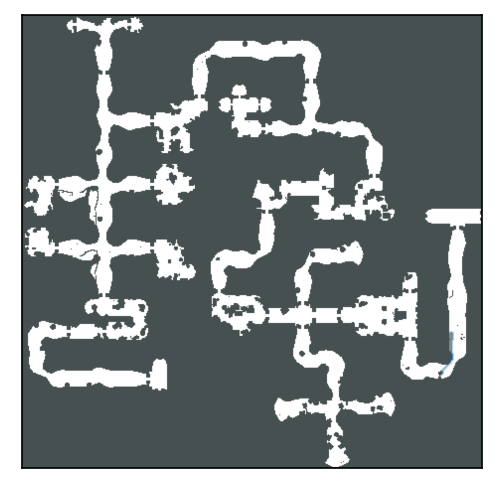

In [23]:
%time astar_len = massive_test(astar, diagonal_distance)["len"]


               Карта 1, JPS               
№0. Path found! Length: 2.414213562373095. Visited: 136. Expanded: 1
№1. Path found! Length: 3.0. Visited: 3. Expanded: 1
№2. Path found! Length: 1.4142135623730951. Visited: 1126. Expanded: 1
№3. Path found! Length: 3.0. Visited: 26. Expanded: 1
№4. Path found! Length: 1.4142135623730951. Visited: 304. Expanded: 1
№5. Path found! Length: 2.414213562373095. Visited: 320. Expanded: 1
№6. Path found! Length: 1.0. Visited: 26. Expanded: 1
№7. Path found! Length: 1.0. Visited: 21. Expanded: 1
№8. Path found! Length: 1.0. Visited: 15. Expanded: 1
№9. Path found! Length: 2.414213562373095. Visited: 28. Expanded: 1
№10. Path found! Length: 5.242640687119285. Visited: 853. Expanded: 1
№11. Path found! Length: 4.414213562373095. Visited: 226. Expanded: 1
№12. Path found! Length: 5.242640687119285. Visited: 108. Expanded: 1
№13. Path found! Length: 7.242640687119285. Visited: 370. Expanded: 1
№14. Path found! Length: 6.0. Visited: 26. Expanded: 1
№15. 

№118. Path found! Length: 46.284271247461895. Visited: 1535. Expanded: 9
№119. Path found! Length: 46.55634918610405. Visited: 998. Expanded: 13
№120. Path found! Length: 48.384776310850235. Visited: 762. Expanded: 2
№121. Path found! Length: 51.48528137423857. Visited: 953. Expanded: 4
№122. Path found! Length: 49.72792206135786. Visited: 592. Expanded: 2
№123. Path found! Length: 50.79898987322333. Visited: 1350. Expanded: 7
№124. Path found! Length: 48.14213562373095. Visited: 1415. Expanded: 9
№125. Path found! Length: 47.48528137423857. Visited: 809. Expanded: 5
№126. Path found! Length: 50.31370849898476. Visited: 818. Expanded: 2
№127. Path found! Length: 48.45584412271571. Visited: 875. Expanded: 9
№128. Path found! Length: 48.38477631085024. Visited: 1217. Expanded: 5
№129. Path found! Length: 48.8700576850888. Visited: 967. Expanded: 3
№130. Path found! Length: 54.97056274847714. Visited: 1152. Expanded: 9
№131. Path found! Length: 55.242640687119284. Visited: 1278. Expanded:

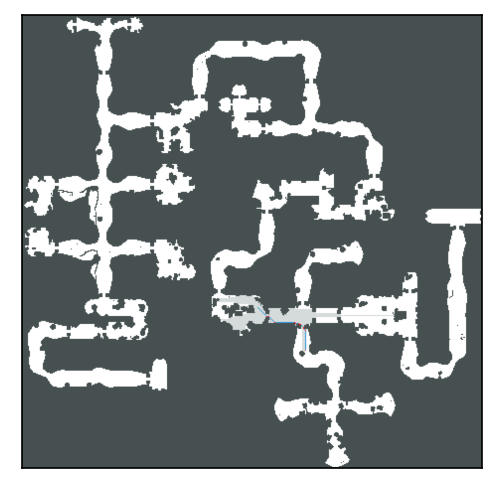

In [24]:
%time jps_len = jps_test()["len"]

In [25]:
assert(len(jps_len) == len(astar_len))

eps = 0.05
for i in range(len(jps_len)):
    if(("True" if jps_len[i] + eps > astar_len[i] and jps_len[i] - eps < astar_len[i] else "False") == "False"):
        print(i, jps_len[i], astar_len[i])

123 50.79898987322333 48.313708498984745
142 59.970562748477136 58.313708498984745
